In [5]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# TensorFlow + Keras (modern unified imports)
from tensorflow.keras.utils import to_categorical  # for one-hot encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [2]:
X_train = np.load("../data/256_192_train.npy")
y_train = np.load("../data/train_labels.npy")
X_val = np.load("../data/256_192_val.npy")
y_val = np.load("../data/val_labels.npy")

In [3]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

y_train.shape , y_val.shape

((8111, 7), (902, 7))

## Loading pretrained vgg16 model

In [4]:
pre_trained_model = VGG16(input_shape=(192,256,3),include_top=False,weights="imagenet")

for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable=False

print(len(pre_trained_model.layers))

2025-05-04 20:45:24.099283: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-04 20:45:24.099310: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-04 20:45:24.099315: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-04 20:45:24.099340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-04 20:45:24.099353: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [5]:
last_layer = pre_trained_model.get_layer("block5_pool")
print(f"last layer shape: {last_layer.output.shape}")
last_output = pre_trained_model.get_layer("block5_pool").output
print(last_output)

last layer shape: (None, 6, 8, 512)
<KerasTensor shape=(None, 6, 8, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_18>


## Model Defination

In [8]:
x = layers.GlobalMaxPooling2D()(last_output)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7,activation='softmax')(x)

model = Model(pre_trained_model.input,x)
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=True
)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 24, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 24, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 24, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 24, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,935 (57.15 MB)

 Trainable params: 266,247 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)


In [8]:
x_sample = X_train[0]
y_sample = y_train[0]

print("X sample shape:", x_sample.shape)
print("Y sample:", y_sample)
print("Is any None in X_train?", any(x is None for x in X_train))
print("Is any None in y_train?", any(y is None for y in y_train))


X sample shape: (192, 256, 3)
Y sample: [0. 0. 1. 0. 0. 0. 0.]
Is any None in X_train? False
Is any None in y_train? False


## Feature-Extraction
If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of feature extraction first so that weights of the final fully connected layer aren't completely random. The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large and will change the pretrained weights too much.

In [7]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [10]:
batch_size = 64
epochs = 3
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3


2025-05-04 20:46:42.726634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 248ms/step - accuracy: 0.5414 - loss: 1.5198 - val_accuracy: 0.6607 - val_loss: 1.0720
Epoch 2/3
  1/126 ━━━━━━━━━━━━━━━━━━━━ 32s 259ms/step - accuracy: 0.7344 - loss: 1.0009

/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7344 - loss: 1.0009 - val_accuracy: 0.6830 - val_loss: 1.0071
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.6475 - loss: 1.1993 - val_accuracy: 0.6317 - val_loss: 1.1233


## Fine Tuning Model
Let's fine tune the last convolutional block of VGG net. I only use learning_rate = 0.0001 with very high momentum = 0.9 and train for 35 epochs only so that the original weights of pretrained VGG net won't be changed too much. learning_rate_reduction function is used and will halve the learning_rate whenever the validation accuracy plateaus for 3 epochs.

In [11]:
for layer in model.layers[:15]:
    layer.trainable=False

for layer in model.layers[15:]:
    layer.trainable=True

In [12]:
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False
)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 24, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 24, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 24, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 24, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,935 (57.15 MB)

 Trainable params: 7,345,671 (28.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.000001,
                                            cooldown = 3)
batch_size = 64
epochs = 30
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[learning_rate_reduction])

/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 292ms/step - acc: 0.6575 - loss: 1.0702 - val_acc: 0.6897 - val_loss: 0.8513 - learning_rate: 1.0000e-04
Epoch 2/30
  1/126 ━━━━━━━━━━━━━━━━━━━━ 37s 302ms/step - acc: 0.6875 - loss: 0.8790

/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.6875 - loss: 0.8790 - val_acc: 0.6808 - val_loss: 0.8577 - learning_rate: 1.0000e-04
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 290ms/step - acc: 0.6931 - loss: 0.9012 - val_acc: 0.7299 - val_loss: 0.7511 - learning_rate: 1.0000e-04
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.7656 - loss: 0.6714 - val_acc: 0.7076 - val_loss: 0.7729 - learning_rate: 1.0000e-04
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 291ms/step - acc: 0.7212 - loss: 0.8091 - val_acc: 0.7210 - val_loss: 0.7158 - learning_rate: 1.0000e-04
Epoch 6/30
  1/126 ━━━━━━━━━━━━━━━━━━━━ 37s 303ms/step - acc: 0.7031 - loss: 0.7831
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.7031 - loss: 0.7831 - val_acc: 0.7143 - val_loss: 0.7507 - learning_rate: 1.0000e-04
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 290ms/step - acc: 0.7270 - loss: 0.7599 - val_acc: 0.7723 - val_loss: 0.6279 - 

In [15]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - acc: 0.7861 - loss: 0.5957
Validation: accuracy = 0.770510  ;  loss_v = 0.632011


### Testing

In [16]:
X_test = np.load('../data/256_192_test.npy')
y_test = np.load('../data/test_labels.npy')
y_test = to_categorical(y_test)

loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - acc: 0.7662 - loss: 0.6608
Test: accuracy = 0.775449  ;  loss = 0.620193


In [17]:
model.save("../models/VGG16.h5")

Text(0.5, 1.0, 'Training and validation loss')

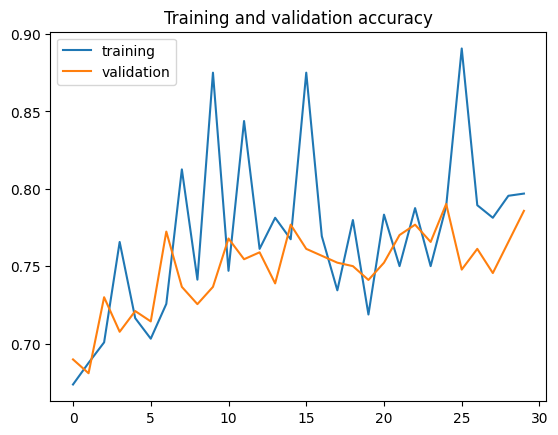

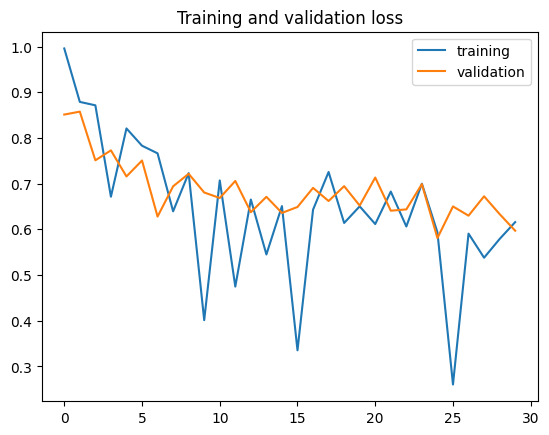

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [2]:
from tensorflow.keras.models import load_model

model = load_model("../models/VGG16.h5")


/Users/ankitsanjyal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2025-05-07 14:39:10.091258: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-07 14:39:10.091293: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-07 14:39:10.091297: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-07 14:39:10.091454: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-07 14:39:10.091463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0

In [6]:
import numpy as np
X_test = np.load('../data/256_192_test.npy')
y_test = np.load('../data/test_labels.npy')
y_test = to_categorical(y_test)

In [ ]:

# y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step


In [ ]:
y_test_pred_classes = np.argmax(y_test_pred, axis=1)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

import numpy as np
X_test = np.load('../data/256_192_test.npy')
y_test = np.load('../data/test_labels.npy')
y_test = to_categorical(y_test)

# --- Predict using the model ---
y_pred_probs = model.predict(X_test)

# --- Convert predicted probabilities to class labels ---
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Convert true labels to class indices if one-hot encoded ---
if y_test.ndim == 2 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# --- Define class names ---
class_names = ['Label A', 'Label B', 'Label C', 'Label D', 'Label E', 'Label F', 'Label G']  # 🔁 change as needed

# --- Print classification report ---
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
              precision    recall  f1-score   support

     Label A     0.5000    0.1429    0.2222        28
     Label B     0.6667    0.5614    0.6095        57
     Label C     0.4497    0.6204    0.5214       108
     Label D     0.0000    0.0000    0.0000        15
     Label E     0.8820    0.9263    0.9036       678
     Label F     0.7857    0.7857    0.7857        14
     Label G     0.5000    0.3431    0.4070       102

    accuracy                         0.7754      1002
   macro avg     0.5406    0.4828    0.4928      1002
weighted avg     0.7591    0.7754    0.7609      1002

